In [1]:
import gzip
import json
from typing import Any, Iterator

import numpy as np
import pandas as pd
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, pairwise_distances
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

# Table of Contents

- [Step A.1](#Step-A.1)
 * [Substep: EDA](#Substep:-EDA)
- [Step A.2](#Step-A.2)
- [Step A.3](#Step-A.3)
- [Step A.4](#Step-A.4)

In [2]:
# download the “small” 5-core dataset for the category "Digital Music"
# dataset source: https://nijianmo.github.io/amazon/index.html

!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz -P data/

--2022-02-13 14:35:33--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19408584 (19M) [application/octet-stream]
Saving to: ‘data/Digital_Music_5.json.gz’

Digital_Music_5.jso 100%[===================>]  18.51M   926KB/s    in 25s     

2022-02-13 14:35:59 (763 KB/s) - ‘data/Digital_Music_5.json.gz’ saved [19408584/19408584]



In [3]:
# download the metadata for this dataset
# dataset source: https://nijianmo.github.io/amazon/index.html

!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Digital_Music.json.gz -P data/

--2022-02-13 14:35:59--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Digital_Music.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12367273 (12M) [application/octet-stream]
Saving to: ‘data/meta_Digital_Music.json.gz’

meta_Digital_Music. 100%[===================>]  11.79M  1.26MB/s    in 34s     

2022-02-13 14:36:33 (352 KB/s) - ‘data/meta_Digital_Music.json.gz’ saved [12367273/12367273]



## Step A.1

The 5-core dataset for the category "Digital Music" subset of the [Amazon Review data](https://nijianmo.github.io/amazon/index.html) in which all users and items have at least 5 reviews.

The format is one-review-per-line in JSON, with the following attributes:

- `reviewerID` - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- `asin` - ID of the product, e.g. 0000013714
- `reviewerName` - name of the reviewer
- `vote` - helpful votes of the review
- `style` - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- `reviewText` - text of the review
- `overall` - rating of the product
- `summary` - summary of the review
- `verified`- whether the review has been verified (boolean)
- `unixReviewTime` - time of the review (unix time)
- `reviewTime` - time of the review (raw)
- `image` - images that users post after they have received the product

Metadata includes descriptions, price, sales-rank, brand info, and co-purchasing links:

- `asin` - ID of the product, e.g. 0000031852
- `title` - name of the product
- `feature` - bullet-point format features of the product
- `description` - description of the product
- `price` - price in US dollars (at time of crawl)
- `imageURL` - url of the product image
- `imageURLHighRes` - url of the high resolution product image
- `related` - related products (also bought, also viewed, bought together, buy after viewing)
- `salesRank` - sales rank information
- `brand` - brand name
- `categories` - list of categories the product belongs to
- `tech1` - the first technical detail table of the product
- `tech2` - the second technical detail table of the product
- `similar_item` - similar product table
- $\dots$

In [4]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [5]:
def parse(filepath: str) -> Iterator[dict]:
    file_obj = gzip.open(filepath, "rb")
    for line in file_obj:
        yield json.loads(line)

In [6]:
def file_to_dataframe(filepath: str) -> pd.DataFrame:
    i = 0
    df = {}
    for d in parse(filepath):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")

In [7]:
review_data = file_to_dataframe("data/Digital_Music_5.json.gz")

inspect_df(review_data)

shape: (169781, 12)


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


In [8]:
list(review_data.columns)

['overall',
 'vote',
 'verified',
 'reviewTime',
 'reviewerID',
 'asin',
 'style',
 'reviewerName',
 'reviewText',
 'summary',
 'unixReviewTime',
 'image']

In [9]:
review_data.loc[2]

overall                                                         5.0
vote                                                            NaN
verified                                                       True
reviewTime                                              02 11, 2014
reviewerID                                           A2VAMODP8M77NG
asin                                                     3426958910
style                                      {'Format:': ' Audio CD'}
reviewerName                                                 JTGabq
reviewText        It was great to hear the old stuff again and I...
summary                                 SLAYER!!!!!!!!!!!!!!!!!!!!!
unixReviewTime                                           1392076800
image                                                           NaN
Name: 2, dtype: object

In [10]:
metadata = file_to_dataframe("data/meta_Digital_Music.json.gz")

inspect_df(metadata)

shape: (74347, 19)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,Master Collection Volume One,"[B000002UEN, B000008LD5, B01J804JKE, 747403435...",,John Michael Talbot,[],"58,291 in CDs & Vinyl (","[B000002UEN, B000008LD5, 7474034352, B000008LD...","<img src=""https://images-na.ssl-images-amazon....",,,$18.99,0001377647,[],[],NaN
1,[],,[],,Hymns Collection: Hymns 1 &amp; 2,"[5558154950, B00014K5V4]",,Second Chapter of Acts,[],"93,164 in CDs & Vinyl (","[B000008KJ3, B000008KJ0, 5558154950, B000UN8KZ...","<img src=""https://images-na.ssl-images-amazon....",,,,0001529145,[],[],NaN
2,[],,[],,Early Works - Don Francisco,"[B00004RC05, B003H8F4NA, B003ZFVHPO, B003JMP1Z...",,Don Francisco,[],"875,825 in CDs & Vinyl (","[B003H8F4NA, B003ZFVHPO, B003JMP1ZK, B00004RC0...","<img src=""https://images-na.ssl-images-amazon....",,,,0001527134,[],[],NaN
3,[],,[],,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2G...",,Keith Green,[],"203,263 in CDs & Vinyl (","[B00000I7JO, B0016CP2GS, 0001393774, B0000275Q...","<img src=""https://images-na.ssl-images-amazon....",,,$13.01,0001388703,[],[],NaN
4,[],,[1. Losing Game 2. I Can't Wait 3. Didn't He S...,,Early Works - Dallas Holm,"[B0002N4JP2, 0760131694, B00002EQ79, B00150K8J...",,Dallas Holm,[],"399,269 in CDs & Vinyl (","[B0002N4JP2, 0760131694, B00150K8JC, B003MTXNV...","<img src=""https://images-na.ssl-images-amazon....",,,,0001526146,[],[],NaN


In [11]:
list(metadata.columns)

['category',
 'tech1',
 'description',
 'fit',
 'title',
 'also_buy',
 'tech2',
 'brand',
 'feature',
 'rank',
 'also_view',
 'main_cat',
 'similar_item',
 'date',
 'price',
 'asin',
 'imageURL',
 'imageURLHighRes',
 'details']

In [12]:
metadata[metadata["asin"] == review_data.loc[2]["asin"]]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
343,[],,[],,Slayer - Greatest Hits 2 CD Set,[],,Slayer,[],"231,252 in CDs &amp; Vinyl (","[B00EBJ62GC, B00BV0W7ZE, B000062YAY, B00EBWHW5...","<img src=""https://images-na.ssl-images-amazon....",,,,3426958910,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [13]:
metadata["asin"].value_counts()

B000091JWJ    2
B0000631GK    2
B00005YTB0    2
B00005YUG3    2
B00005YUJP    2
             ..
B0013V1TLO    1
B0013V6TG4    1
B0013VANYI    1
B0013V9Q6E    1
B01HIT3KZC    1
Name: asin, Length: 66013, dtype: int64

In [14]:
metadata.drop_duplicates(subset="asin", keep="first", inplace=True)

In [15]:
# for the content-based RecSys, we need both the review rating & title, description attrs - so an inner join
data = pd.merge(review_data, metadata, how="inner", on="asin")

inspect_df(data)

shape: (2383, 30)


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,...,feature,rank,also_view,main_cat,similar_item,date,price,imageURL,imageURLHighRes,details
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,...,[],"231,252 in CDs &amp; Vinyl (","[B00EBJ62GC, B00BV0W7ZE, B000062YAY, B00EBWHW5...","<img src=""https://images-na.ssl-images-amazon....",,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,...,[],"231,252 in CDs &amp; Vinyl (","[B00EBJ62GC, B00BV0W7ZE, B000062YAY, B00EBWHW5...","<img src=""https://images-na.ssl-images-amazon....",,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,...,[],"231,252 in CDs &amp; Vinyl (","[B00EBJ62GC, B00BV0W7ZE, B000062YAY, B00EBWHW5...","<img src=""https://images-na.ssl-images-amazon....",,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,...,[],"231,252 in CDs &amp; Vinyl (","[B00EBJ62GC, B00BV0W7ZE, B000062YAY, B00EBWHW5...","<img src=""https://images-na.ssl-images-amazon....",,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,5.0,NaN,True,"01 7, 2015",A3HUD6U7RWX8E8,3426958910,{'Format:': ' Audio CD'},Kevin Ross,Excellent.,Five Stars,...,[],"231,252 in CDs &amp; Vinyl (","[B00EBJ62GC, B00BV0W7ZE, B000062YAY, B00EBWHW5...","<img src=""https://images-na.ssl-images-amazon....",,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [16]:
metadata[metadata["asin"] == "B000091JWJ"]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
7771,[],,[CD Rare 1989 15Trks],,This Is Music 6,[],,VARIOUS ARTISTS,[],"1,661,837 in CDs & Vinyl (",[],"<img src=""https://images-na.ssl-images-amazon....",,,$2.89,B000091JWJ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,"{'Audio CD': '(February 2, 2018)', 'Number of ..."


### Substep: EDA

In [17]:
data["created_at"] = pd.to_datetime(data["unixReviewTime"], unit="s")
data["created_at"] = pd.to_datetime(data["created_at"], format="%Y-%m")

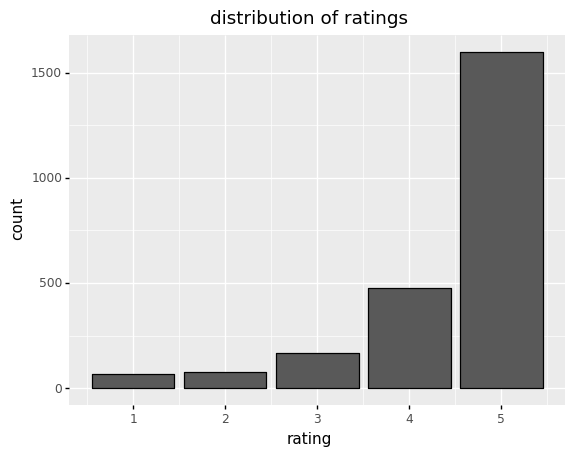

<ggplot: (8769585813607)>

In [18]:
(
    ggplot(data, aes(x="overall"))
    + geom_bar(color="black")
    + labs(x="rating", title="distribution of ratings")
)

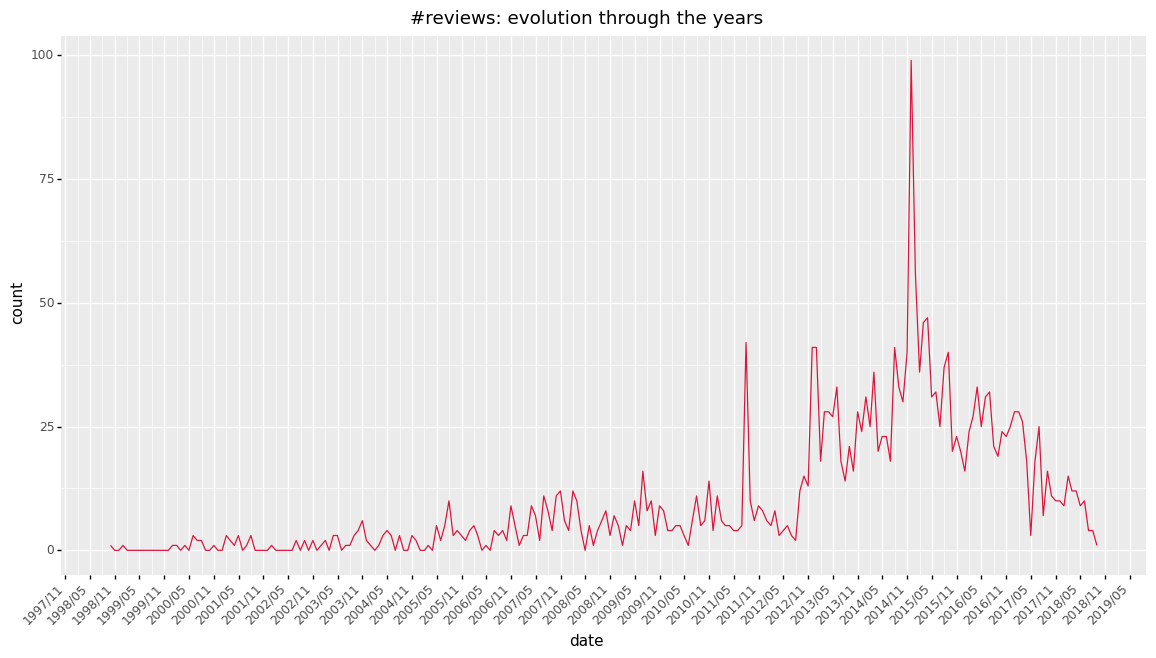

<ggplot: (8769585888823)>

In [19]:
(
    ggplot(data.groupby(pd.Grouper(key="created_at", freq="M")).count().reset_index())
    + geom_line(aes(x="created_at", y="asin"), color="crimson")
    + labs(x="date", y="count", title="#reviews: evolution through the years")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

/home/iantonopoulos/.cache/pypoetry/virtualenvs/recommender-systems-rVb3Y5Fg-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


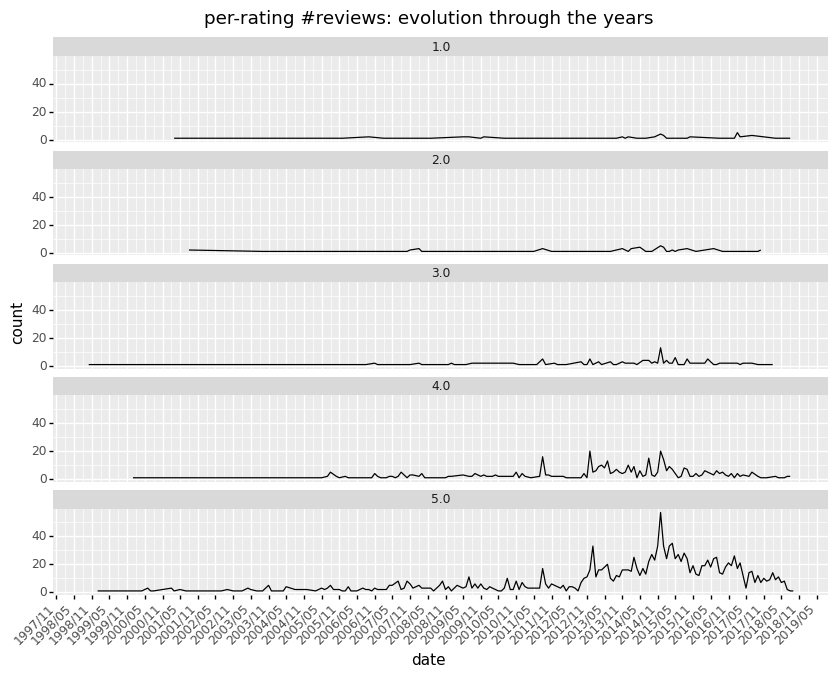

<ggplot: (8769580037901)>

In [20]:
(
    ggplot(
        data.groupby([pd.Grouper(key="created_at", freq="M"), "overall"])
        .count()
        .reset_index()
    )
    + geom_line(aes(x="created_at", y="asin"))
    + facet_wrap("overall", ncol=1)
    + labs(
        x="date", y="count", title="per-rating #reviews: evolution through the years"
    )
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(10, 7))
)

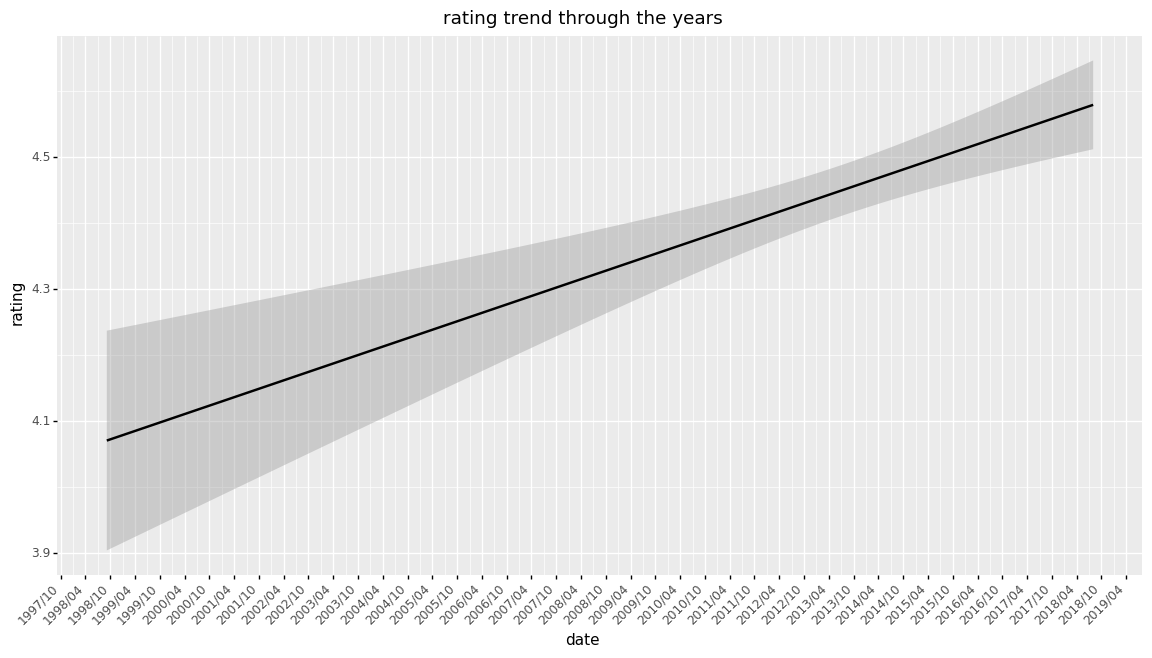

<ggplot: (8769578029111)>

In [21]:
(
    ggplot(data)
    + geom_smooth(aes(x="created_at", y="overall"))
    + labs(x="date", y="rating", title="rating trend through the years")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

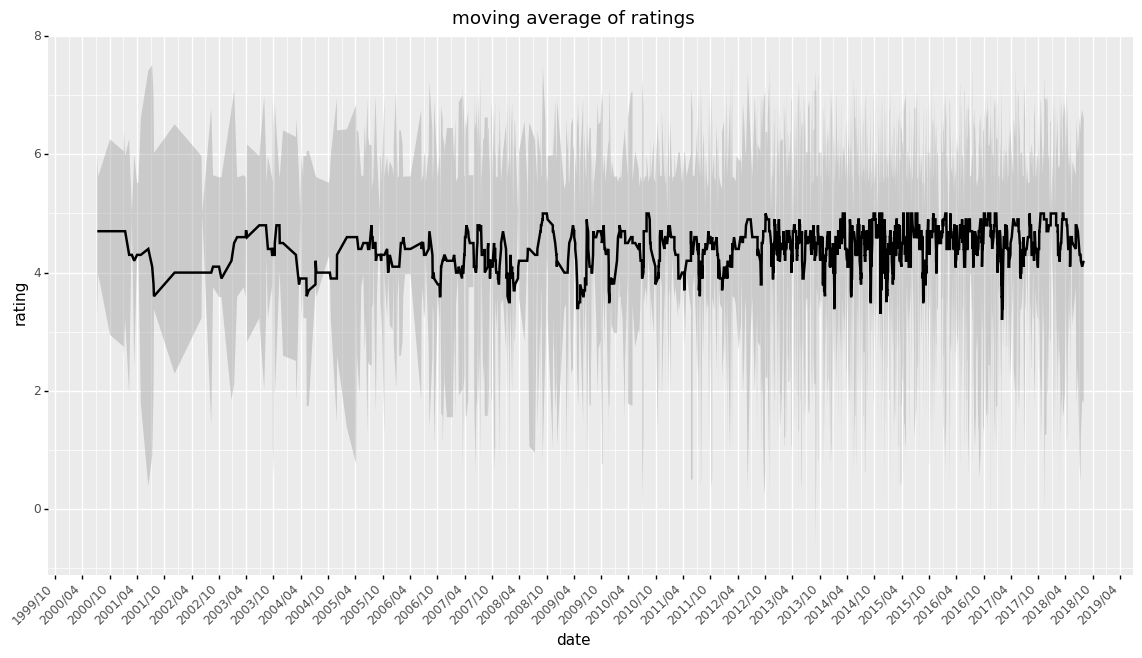

<ggplot: (8769578031315)>

In [22]:
(
    ggplot(data)
    + geom_smooth(
        aes(x="created_at", y="overall"), method="mavg", method_args={"window": 10}
    )
    + labs(x="date", y="rating", title="moving average of ratings")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

## Step A.2

Our objective is to construct “item profiles” for the items, based on information available on their metadata.

In [23]:
content = data.copy()

In [24]:
content["title"].map(lambda x: isinstance(x, str)).value_counts()

True    2383
Name: title, dtype: int64

In [25]:
content["description"].map(lambda x: isinstance(x, list)).value_counts()

True    2383
Name: description, dtype: int64

In [26]:
content["description"]

0                []
1                []
2                []
3                []
4                []
           ...     
2378    [Brand new]
2379    [Brand new]
2380    [Brand new]
2381    [Brand new]
2382    [Brand new]
Name: description, Length: 2383, dtype: object

In [27]:
content[content["description"].map(len) > 1]["description"]

15                                          [Book by, , ]
16                                          [Book by, , ]
17                                          [Book by, , ]
18                                          [Book by, , ]
19                                          [Book by, , ]
                              ...                        
1441    [2 complete shows, once missing reels filled w...
1442    [2 complete shows, once missing reels filled w...
1443    [2 complete shows, once missing reels filled w...
1444    [2 complete shows, once missing reels filled w...
1445    [2 complete shows, once missing reels filled w...
Name: description, Length: 196, dtype: object

In [28]:
def concatenate_list_field(field: list) -> str:

    if not isinstance(field, list):
        return TypeError

    return " ".join(field)

In [29]:
content["description"] = content["description"].map(concatenate_list_field)

In [30]:
transformer = FeatureUnion(
    [
        (
            "title_tfidf",
            Pipeline(
                [
                    (
                        "extract_field",
                        FunctionTransformer(lambda x: x["title"], validate=False),
                    ),
                    ("tfidf", TfidfVectorizer()),
                ]
            ),
        ),
        (
            "description_tfidf",
            Pipeline(
                [
                    (
                        "extract_field",
                        FunctionTransformer(lambda x: x["description"], validate=False),
                    ),
                    ("tfidf", TfidfVectorizer()),
                ]
            ),
        ),
    ]
)

In [31]:
transformer.fit(content)

FeatureUnion(transformer_list=[('title_tfidf',
                                Pipeline(steps=[('extract_field',
                                                 FunctionTransformer(func=<function <lambda> at 0x7f9d3b3e7940>)),
                                                ('tfidf', TfidfVectorizer())])),
                               ('description_tfidf',
                                Pipeline(steps=[('extract_field',
                                                 FunctionTransformer(func=<function <lambda> at 0x7f9d3b3e78b0>)),
                                                ('tfidf',
                                                 TfidfVectorizer())]))])

In [32]:
title_vocab = transformer.transformer_list[0][1].steps[1][1].get_feature_names_out()
description_vocab = (
    transformer.transformer_list[1][1].steps[1][1].get_feature_names_out()
)

In [33]:
len(title_vocab), len(description_vocab)

(495, 2598)

In [34]:
transformed_content = transformer.transform(content).toarray()

transformed_content.shape

(2383, 3093)

## Step A.3

In [35]:
# note that the TF-IDF functionality in sklearn.feature_extraction.text can produce
# normalized vectors, in which case cosine_similarity is equivalent to linear_kernel,
# only slower.
cosine_sim_matrix = linear_kernel(transformed_content, transformed_content)

cosine_sim_matrix.shape

(2383, 2383)

In [36]:
jaccard_sim_matrix = 1 - pairwise_distances(transformed_content, metric="jaccard")

jaccard_sim_matrix.shape

/home/iantonopoulos/.cache/pypoetry/virtualenvs/recommender-systems-rVb3Y5Fg-py3.8/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard


(2383, 2383)

In [37]:
def get_recommendations(
    data: pd.DataFrame,
    query: str,
    column: str,
    similarity_matrix: np.ndarray,
    limit: int = 10,
) -> pd.DataFrame:
    """
    Retrieves the top content recommendations based on a similarity matrix.

    Args:
        data: tabulation containing the text data.
        column: name of column used, i.e. 'title'.
        query: query to get recommendations for.
        cosine_similarities: matrix with similarities.
        limit: the number of recommendations to return.

    Returns:
        The top content recommendations.
    """
    # create an index mapping
    df = data.drop_duplicates(subset=column)
    indices = pd.Series(df.index, index=df[column]).drop_duplicates()

    # get the index for the target query
    try:
        target_index = indices[query]
    except KeyError:
        raise KeyError(f"query <{query}> does not exist in provided data.") from None

    # get the similarity scores for the target query
    similarity_scores = list(enumerate(similarity_matrix[target_index]))

    # sort the similarities, with the most similar first
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # get the m closest scores (according to `limit`), excluding the query
    similarity_scores = similarity_scores[1 : limit + 1]

    df = pd.DataFrame(similarity_scores, columns=["index", "similarity_score"])
    df["recommendation"] = data[column].iloc[[ix for ix, _ in similarity_scores]].values

    return df

In [38]:
get_recommendations(
    content,
    query="Wake Up the World",
    column="title",
    similarity_matrix=jaccard_sim_matrix,
)

,index,similarity_score,recommendation
0,460,0.142857,Kids Praise 3 CD
1,461,0.142857,Kids Praise 3 CD
2,462,0.142857,Kids Praise 3 CD
3,463,0.142857,Kids Praise 3 CD
4,464,0.142857,Kids Praise 3 CD
5,1223,0.141509,Still Believe
6,1224,0.141509,Still Believe
7,1225,0.141509,Still Believe
8,1226,0.141509,Still Believe
9,1227,0.141509,Still Believe


In [39]:
get_recommendations(
    content,
    query="Slayer - Greatest Hits 2 CD Set",
    column="title",
    similarity_matrix=jaccard_sim_matrix,
)

,index,similarity_score,recommendation
0,1,1.00,Slayer - Greatest Hits 2 CD Set
1,2,1.00,Slayer - Greatest Hits 2 CD Set
2,3,1.00,Slayer - Greatest Hits 2 CD Set
3,4,1.00,Slayer - Greatest Hits 2 CD Set
4,1454,0.25,Amazon Exclusive (4 CD set + Bonus CD)
5,1455,0.25,Amazon Exclusive (4 CD set + Bonus CD)
6,1456,0.25,Amazon Exclusive (4 CD set + Bonus CD)
7,1457,0.25,Amazon Exclusive (4 CD set + Bonus CD)
8,1458,0.25,Amazon Exclusive (4 CD set + Bonus CD)
9,1459,0.25,Amazon Exclusive (4 CD set + Bonus CD)


In [40]:
get_recommendations(
    content,
    query="James Marsters second solo album\n\nLike A Waterfall (2007)\n\n1. Not A Millionaire\n2. Looking At you\n3. Don't Worry Son\n4. Birth Of The Blues\n5. White Hot Girls\n6. London City\n7. Up On Me\n8. Like A Waterfall\n9. Louise\n10. When I Was A Baby\n11. Layabout\n12. Too Fast",
    column="description",
    similarity_matrix=jaccard_sim_matrix,
)

,index,similarity_score,recommendation
0,1769,0.22449,Ronnie Dunn's second solo album release.
1,1770,0.22449,Ronnie Dunn's second solo album release.
2,1771,0.22449,Ronnie Dunn's second solo album release.
3,1772,0.22449,Ronnie Dunn's second solo album release.
4,1773,0.22449,Ronnie Dunn's second solo album release.
5,1774,0.22449,Ronnie Dunn's second solo album release.
6,1775,0.22449,Ronnie Dunn's second solo album release.
7,1776,0.22449,Ronnie Dunn's second solo album release.
8,1777,0.22449,Ronnie Dunn's second solo album release.
9,1778,0.22449,Ronnie Dunn's second solo album release.


In [41]:
get_recommendations(
    content,
    query="Wake Up the World",
    column="title",
    similarity_matrix=cosine_sim_matrix,
)

,index,similarity_score,recommendation
0,2364,0.576116,Save The World
1,2365,0.576116,Save The World
2,2366,0.576116,Save The World
3,2367,0.576116,Save The World
4,1600,0.395593,Thor the Dark World
5,1601,0.395593,Thor the Dark World
6,1602,0.395593,Thor the Dark World
7,1603,0.395593,Thor the Dark World
8,1604,0.395593,Thor the Dark World
9,1223,0.335147,Still Believe


In [42]:
get_recommendations(
    content,
    query="Slayer - Greatest Hits 2 CD Set",
    column="title",
    similarity_matrix=cosine_sim_matrix,
)

,index,similarity_score,recommendation
0,1,1.000000,Slayer - Greatest Hits 2 CD Set
1,2,1.000000,Slayer - Greatest Hits 2 CD Set
2,3,1.000000,Slayer - Greatest Hits 2 CD Set
3,4,1.000000,Slayer - Greatest Hits 2 CD Set
4,1185,0.586672,Coldplay - Greatest Hits 2 Cd Set [2011]
5,1186,0.586672,Coldplay - Greatest Hits 2 Cd Set [2011]
6,1187,0.586672,Coldplay - Greatest Hits 2 Cd Set [2011]
7,1188,0.586672,Coldplay - Greatest Hits 2 Cd Set [2011]
8,1189,0.586672,Coldplay - Greatest Hits 2 Cd Set [2011]
9,990,0.379757,The Greatest Hits of the Everly Brothers


In [43]:
get_recommendations(
    content,
    query="James Marsters second solo album\n\nLike A Waterfall (2007)\n\n1. Not A Millionaire\n2. Looking At you\n3. Don't Worry Son\n4. Birth Of The Blues\n5. White Hot Girls\n6. London City\n7. Up On Me\n8. Like A Waterfall\n9. Louise\n10. When I Was A Baby\n11. Layabout\n12. Too Fast",
    column="description",
    similarity_matrix=cosine_sim_matrix,
)

,index,similarity_score,recommendation
0,1769,1.142651,Ronnie Dunn's second solo album release.
1,1770,1.142651,Ronnie Dunn's second solo album release.
2,1771,1.142651,Ronnie Dunn's second solo album release.
3,1772,1.142651,Ronnie Dunn's second solo album release.
4,1773,1.142651,Ronnie Dunn's second solo album release.
5,1774,1.142651,Ronnie Dunn's second solo album release.
6,1775,1.142651,Ronnie Dunn's second solo album release.
7,1776,1.142651,Ronnie Dunn's second solo album release.
8,1777,1.142651,Ronnie Dunn's second solo album release.
9,1778,1.142651,Ronnie Dunn's second solo album release.


## Step A.4